# Creating Heatmaps for Visualizing Convnets

---
## Introduction 
Neural networks are often described as a black box. You provide an input and you get an output, but it can be hard to understand what happened inbetween. In this post, we'll look at the Grad-CAM algorithm which will help us understand why our convnet makes the predictions it does. In the end, we'll be able to provide an image, see the predicted class, and see a heatmap of what led to that prediction. You can find the original paper here: [_Grad CAM: Visual Explanations from Deep Networks via Gradient-based Localization_](https://arxiv.org/pdf/1610.02391.pdf). The authors list the following benefits of Grad-CAM

>  In the context of image classification
models, our visualizations (a) lend insights into
failure modes of these models (showing that seemingly unreasonable
predictions have reasonable explanations), (b)
are robust to adversarial images, (c) outperform previous
methods on the ILSVRC-15 weakly-supervised localization
task, (d) are more faithful to the underlying model, and (e)
help achieve model generalization by identifying dataset
bias

We are going to use VGG16 for this post, but you could use any pretrained convnet. In the end, we want to get an easy-to-use function like the one below. We're going to begin with `generate_heatmap()` as that's the actual Grad-CAM algorithm, and we'll fill in the other details later.
```python 
def class_activation_map(model, layer, img_path, preprocess):
    """Creates a class activation map for the given image. 
    
    Uses the Grad-CAM algorithm to overlay a class activation 
    map on the given image using the image's predicted class. 
    Saves the overlayed image in the same path with 'cam' 
    appended to filename.
    
    Arguments:
        - model: The network architecture 
        - layer: The name of the last conv layer 
        - img_path: The full path to the image 
        - preprocess: A function handle to prepare the image
        
    Returns
        - An image with the heatmap overlayed and the path to it.  
    """
    image = preprocess(img_path)
    heatmap = generate_heatmap(model, layer, image)
    cam_image = overlay_heatmap(img_path, heatmap)
    cam_path = save_cam_image(cam_image, img_path)
    return cam_image, cam_path
```

Before we begin let's import some packages and load VGG16

In [1]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import keras.backend as K 
import numpy as np 
import cv2 
import os

model = VGG16(weights='imagenet')
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

---
## The Grad-CAM Algorithm
The algorithm is actually pretty simple to follow, so I'd recommend looking at section 3 (Approach) of the original paper for a better understanding. It is only 1 page 👌. I'll provide snippets of the general idea below. 

#### Overview
We are going to select the final convolutional layer in our network. 

> A number of previous works have asserted that deeper
representations in a CNN capture higher-level visual constructs. Furthermore, convolutional features naturally
retain spatial information which is lost in fully-connected
layers, so we can expect the last convolutional layers to
have the best compromise between high-level semantics and
detailed spatial information.

Then, we are going to visualize the importance of each neuron in our prediction

>  Grad-CAM uses the gradient information
flowing into the last convolutional layer of the CNN
to understand the importance of each neuron for a decision
of interest.

#### Algorithm
1) To do this, we first compute the gradient of the predicted class with respect to the final convolutional layer $A^k$

$$\frac{\partial y^c}{\partial A^k}$$

2) We average-pool the gradients to obtain the _neuron importance weights_ $\alpha_k^c$.

$$\alpha_k^c = \frac{1}{Z}\sum_i\sum_j \frac{\partial y^c}{\partial A_{ij}^k}$$

3) Then, we multiply the activation map by the neuron importance weights

$$\sum_k \alpha_k^c A^k$$

4) Finally we apply a ReLU to this result

$$ReLU\big(\sum_k \alpha_k^c A^k \big)$$

The reasoning for using the ReLU is well explained in the paper

> We apply a ReLU to the linear combination of
maps because we are only interested in the features that
have a positive influence on the class of interest, i.e. pixels
whose intensity should be increased in order to increase $y^c$
Negative pixels are likely to belong to other categories in
the image. As expected, without this ReLU, localization
maps sometimes highlight more than just the desired class
and achieve lower localization performance.

#### Implementation
The code for this is shown below.

In [2]:
def generate_heatmap(model, layer, image):
    """Uses the Grad-CAM algorithm to create a heatmap."""
    # We define a dictionary: layer name => layer output 
    # 
    # This allows us to easily select the output of our final 
    # convolutional layer as needed for the algorithm. The final 
    # line of code gets the number of channels in the final layer. 
    # We need the number of channels for step 3, where we multiply
    # the activations by the neuron importance weights.
    model_layers = {layer.name: layer.output for layer in model.layers}
    last_conv_layer_output = model_layers[layer]
    last_conv_layer_num_channels = int(last_conv_layer_output.shape[-1])
    
    # We define the computations necessary for Grad-CAM
    #
    # Next, we tell keras we want to get the gradient of the output 
    # prediction with respect to the output of our final 
    # convolutional layer. Then, we define the pooled gradient 
    # which is what we needed to compute in step 2. At this point, 
    # nothing has been computed, it has just been defined. 
    prediction = np.argmax(model.predict(image)[0])
    model_output = model.output[:, prediction]
    gradient = K.gradients(model_output, last_conv_layer_output)[0]
    pooled_gradient = K.mean(gradient, axis=(0,1,2))
    
    # Function: input image => get pooled gradients and last conv layer 
    get_targets = K.function([model.input], 
                             [pooled_gradient, last_conv_layer_output[0]])
    
    # Step 1 and 2: Computes the pooled gradients 
    pooled_grads_value, conv_layer_output_value = get_targets([image])
    
    # Step 3: Multiply the activations by the neuron importance weights
    for i in range(last_conv_layer_num_channels):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i] 
       
    # Step 4: Average the channels, take the ReLU, scale the heatmap
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / np.max(heatmap)
    return heatmap 

---
## Visualizing the Heatmap
Let's try this out and see how the results work.  

#### Loading an Image
Before we can test our heatmap function, we'll have to load and preprocess an image. VGG16 uses 224x224 images, so we'll scale to that size, convert the image to an array, and finally we'll use the `preprocess_input` function from `keras.applications.vgg16`. 

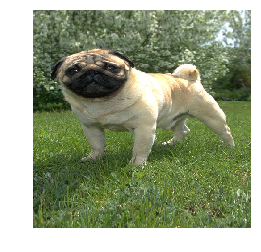

In [3]:
def preprocess(img_path):
    """Load and preprocess an image for the given model."""
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

# Load a pug photo 
base_path = '/Users/jtbergman/GitHub/deep-learning-code/cnn04/images/'
image_path = base_path + 'pug_photo.jpg'
img = preprocess(image_path)

# Display the pug photo
plt.imshow(image.load_img(image_path, target_size=(224, 224)))
plt.axis('off')
plt.show()

#### Creating the Heatmap
To use the function, we have to provide our model (VGG16) and the layer to use. As mentioned previously, the paper recommends using the final layer of the convnet.  From the model summary above we can see that the final conv layer is 'block5_conv3'. If you're curious, try changing the conv layer you're passed in and see how the heatmap changes. 

Finally, note that the heatmap has the same dimensions as the final convolutional layer. Therefore, we're going to have to rescale it to fit the original image. Already, however, we can see that the heatmap is approximately where the pug's head would be.

Shape: (14, 14)


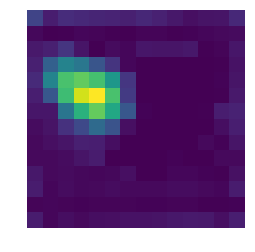

In [4]:
heatmap = generate_heatmap(model, 'block5_conv3', img)
print('Shape:', heatmap.shape)
plt.imshow(heatmap)
plt.axis('off')
plt.show()

#### Rescaling the Heatmap
We will use OpenCV (cv2) to load the original image and apply the heatmap.

In [5]:
def overlay_heatmap(img_path, heatmap):
    """Adds the heatmap over the original image."""
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    return heatmap * 0.4 + img 

cam = overlay_heatmap(image_path, heatmap)

Then we will write a helper to save the CAM in the same directory. 

In [6]:
def save_cam_image(image, orig_path):
    """Saves the cam image at the original path with '_cam' added."""
    directory = os.path.dirname(orig_path)
    bname = os.path.basename(orig_path)
    bname_components = bname.split('.')
    fname = bname_components[0] + '_cam.' + bname_components[1]
    fpath = os.path.join(directory, fname)
    cv2.imwrite(fpath, image)
    return fpath

cpath = save_cam_image(cam, image_path)

#### Visualizing the Class Activation Map
Now let's view the final class activation map. As you can see, the model accurately predicts "pug" and it shows that the pug's face was what led to that prediction! 

Prediction: pug


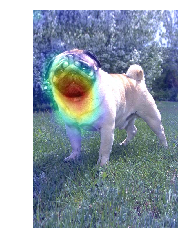

In [7]:
# Helpers
def display_cam(cam_image_path):
    """Displays the CAM from its file path."""
    img=mpimg.imread(cam_image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
def display_prediction(img_path):
    """Displays a prediction for the VGG16 model"""
    img = preprocess(image_path)
    prediction = decode_predictions(model.predict(img), top=1)[0][0][1]
    print('Prediction:', prediction)
    
# Display the predicted class and the CAM 
display_prediction(image_path)
display_cam(cpath)

---
## Grad-CAM: Additional Examples
Let's combine the above functions into a single function and look at several other images.

#### Complete Grad-CAM Implementation

In [8]:
def class_activation_map(model, layer, img_path, preprocess):
    """Creates a class activation map for the given image. 
    
    Uses the Grad-CAM algorithm to overlay a class activation map on 
    the given image using the image's predicted class. Saves the 
    overlayed image in the same path with 'cam' appended to filename.
    
    Arguments:
        - model: The network architecture 
        - layer: The name of the last conv layer 
        - img_path: The full path to the image 
        - preprocess: A function handle to prepare the image for the model
        
    Returns:
        - An image with the heatmap overlayed and the path to it.  
    """
    image = preprocess(img_path)
    heatmap = generate_heatmap(model, layer, image)
    cam_image = overlay_heatmap(img_path, heatmap)
    cam_path = save_cam_image(cam_image, img_path)
    return cam_image, cam_path

#### Additional Examples

Prediction: pug


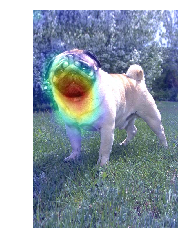

Prediction: African_elephant


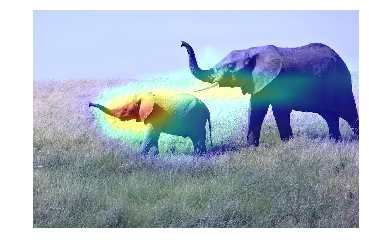

Prediction: tiger_cat


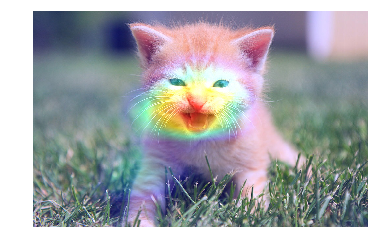

Prediction: sports_car


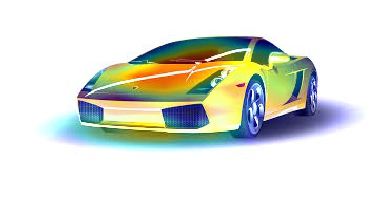

In [9]:
base_path = '/Users/jtbergman/GitHub/deep-learning-code/cnn04/images/'

# Display the pug prediction and class activation map
image_path = base_path + 'pug_photo.jpg'
display_prediction(image_path)
cam, cpath = class_activation_map(model, 'block5_conv3', image_path, preprocess)
display_cam(cpath)

# Display the elephant prediction and class activation map  
image_path = base_path + 'elephant.jpg'
display_prediction(image_path)
cam, cpath = class_activation_map(model, 'block5_conv3', image_path, preprocess)
display_cam(cpath)

# Display the kitten prediction and class activation map
image_path = base_path + 'kitten.jpg'
display_prediction(image_path)
cam, cpath = class_activation_map(model, 'block5_conv3', image_path, preprocess)
display_cam(cpath)

# Display the car prediction and class activation map
image_path = base_path + 'car.jpg'
display_prediction(image_path)
cam, cpath = class_activation_map(model, 'block5_conv3', image_path, preprocess)
display_cam(cpath)

---
## Summary
As you can see, we get some pretty good results!

### References
[_Grad CAM: Visual Explanations from Deep Networks via Gradient-based Localization_](https://arxiv.org/pdf/1610.02391.pdf)

### Photos
+ [Pug Photo](https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/12225427/Pug-Care.jpg)
+ [Elephant Photo](https://www.seattleglobalist.com/wp-content/uploads/2016/07/female-elephant-341983_1280.jpg)
+ [Kitten Photo](https://c1.staticflickr.com/8/7111/27158365900_6c0325037d_b.jpg)
+ [Car Photo](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSrnOPYl2hGy8KBlTKZYuQ-ha9AxoJmlEF7jsRBCva3qjQpzUnW4g)